# Data Analytics 

## Prediction of Thoroughbred horses' value basing on parent matching

Authors: 

Michał Motyl
Kamil Pieprzycki

### Problem describtion

The aim of the project is to predict the potential value of racehorses obtained through parental crossbreeding. The main objective is to analyze the impact of sporting results and, based on that analysis, create models that will allow the estimation of investment value.

The reasearch can be a valuable information for investors and horsebreeders to predict investment profitability in horses trening and breeding. The potential usecase is to evaulate value of the young horse with the data of parent and on this basis check if is it worth to invest.

Data used for the purpose of this assignment comes from following website:

- https://sporthorse-data.com/pedigree - Data Base containg information about horses' statisctics and characteristics

Together with individual knowledge of the topic(ownership of Thoroughbred horse bought on auction) we were able to make informed assumtions to help with overall process 

### DAG dodać mamy


The value of a horse is influenced by numerous variables, including some undefined ones such as individual training or rearing location. For the purposes of the project, assumptions were made to minimize their significance. The dataset consists of randomly selected horses that competed in races within a specified timeframe of 1968 to 1975 in the United States. With these assumptions, it can be inferred that rearing techniques and training methods were very similar. Additionally, the factor of jockeys in races with very similar physical conditions was omitted.

As additional factors can be assumed horse's height, allergies or illnesses, however data was incomplete and therefore their effects cound not be investigated in the project. According to our reaserch height has no corelation with the sport results and ill horses do not participate in races.


As input values 10 variables were chosen as influential initial raw after data analysis:

- Stalion's racing starts count
- Stalion's Number of 1st places
- Stalion's Number of 2nd places
- Stalion's Number of 3rd places
- Stalion's value
- Mare's racing starts count
- Mare's Number of 1st places
- Mare's Number of 2nd places
- Mare' sNumber of 3rd places
- Mare's value






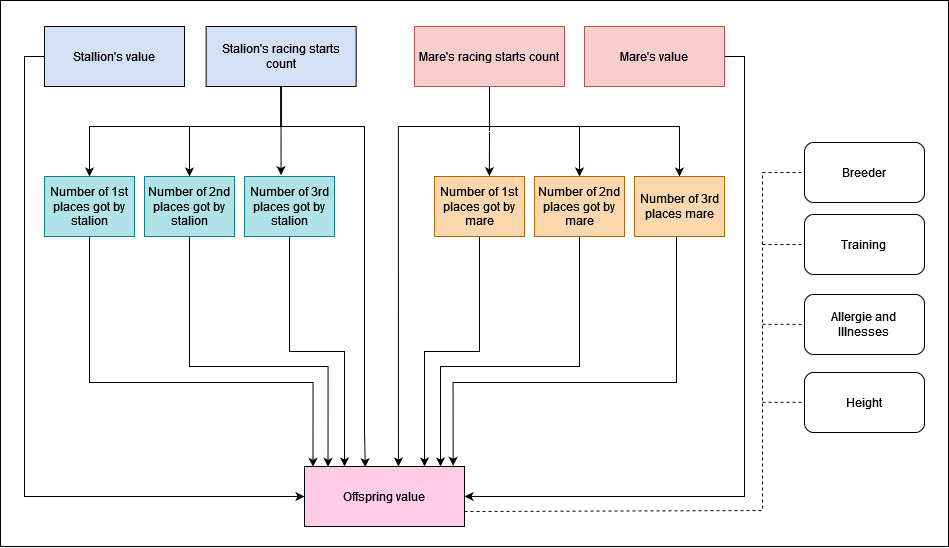

In [37]:
from PIL import Image
image = Image.open("OFFSPRING_DAG.jpg")
display(image)

Our DAG contains 1 main counfounding that is:
- Stalion Racing Starts Count

It contains 1 fork:
- Stalion Racing Starts Count ---> (Number of 1st, 2nd, 3rd places) AND (Offspring value)

There is 1 collider:
- All our data influences the variable to be predicted - Offspring value




In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import scipy
from cmdstanpy import CmdStanModel
from cmdstanpy import install_cmdstan

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation - Loading full datasets  to poprawić skalowanie i opis


The main data preparation steps were done in `data_prep.ipynb`. In said notebook we have connected offspring data together with parents data via correct id's. After that a correlation analysis was performed. Based on said analysis we have noticed that only noticably important data fields in correlation to offspring value are its first places, and the number of starts of its dad together with dad's value. The main factors correlating to offsprings first places were dads number of places at 1st, 2nd and 3rd place. We have discovered that the mother's parameters were virtually not important at all in relation to offsprings value. 

Additionally, we have limited ourselfes to analysing male offspring - male and female offspring had different distributions for their values, thus one model would be not appropriate for both at the same time (also, buying stallions rather than mares is way more common). Finally, the interesting columns were selected and saved in two csv files - combined data for offspring with dads in file `only_stalions_prepared.csv`, and for analysis purposes also dads' data in `dads_prep.csv`, both can be found in folder `data_prepared`.

In [3]:
# imports
path_to_prepared_data = 'data/data_prepared/prepared_horses_stallions.csv'
df = pd.read_csv(path_to_prepared_data)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 0 to 39
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         34 non-null     int64  
 1   kid_id             34 non-null     int64  
 2   mum_id             34 non-null     object 
 3   dad_id             34 non-null     object 
 4   value_numeric      34 non-null     float64
 5   dad_value_numeric  34 non-null     float64
 6   dad_first_place    34 non-null     float64
 7   dad_second_place   34 non-null     float64
 8   dad_third_place    34 non-null     float64
 9   dad_num_of_starts  34 non-null     float64
 10  mum_value_numeric  34 non-null     float64
 11  mum_first_place    34 non-null     float64
 12  mum_second_place   34 non-null     float64
 13  mum_third_place    34 non-null     float64
 14  mum_num_of_starts  34 non-null     float64
dtypes: float64(11), int64(2), object(2)
memory usage: 4.2+ KB


In [4]:
from sklearn.preprocessing import StandardScaler

# rescaling values
df_copy = df.drop(['kid_id', 'mum_id', 'dad_id', 'Unnamed: 0'], axis=1)
columns_names = df_copy.columns
scaler = StandardScaler()
scaler.fit(df_copy)
df_copy = pd.DataFrame(scaler.transform(df_copy))
df_copy.columns = columns_names

# x - mu
# ------
#  sig

df_copy.head()

,value_numeric,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts,mum_value_numeric,mum_first_place,mum_second_place,mum_third_place,mum_num_of_starts
0,-0.384668,-0.728872,-0.561859,-0.997735,-1.306751,-0.985619,-0.288988,0.017552,0.339877,0.594964,0.006827
1,1.171778,3.075186,3.281389,1.670366,2.884715,3.093986,-0.288988,0.017552,0.339877,0.594964,0.006827
2,-0.770187,0.284287,0.003325,-0.616578,0.369835,-0.402818,-0.288988,0.017552,0.339877,0.594964,0.006827
3,-0.783174,0.284287,0.003325,-0.616578,0.369835,-0.402818,-0.288988,0.017552,0.339877,0.594964,0.006827
4,-0.145631,1.707055,0.794581,1.289209,1.208128,0.617083,-0.443615,-0.579215,-0.993485,1.100684,0.006827


## Data Exploration

### Histogram of date we want to predict

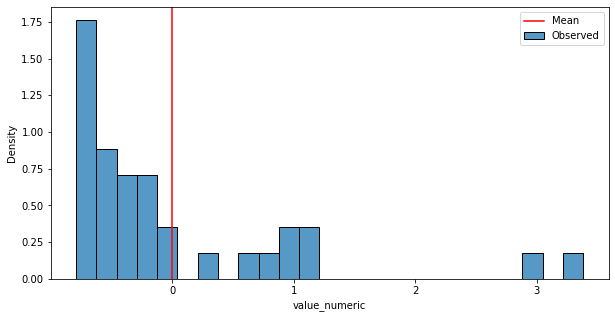

In [5]:
# analysis of value: what we want to to predict
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df_copy, x='value_numeric', bins=25, ax=axs, label='Observed',stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='red', label='Mean')
graph.legend()
plt.show()


Generated histogram seems to be similiar to either lognormal or tstudent distribution (there are also of course other more advanced distribuitions that would potentially fit here, however the easiest solutions should be checked first, thus we went with such choices later on).

# Model 1 describtion zamienić na model DODAĆ MARGINAL DISTRIBUTIONS

1. The lognormal distribution was chosen as the first model for predicting offspring values, as it was deemed the most suitable for our case.
2. The chosen distribution is suitable because the majority of horses being sold are priced lower, as it is an auction market and we do not assume any upper limits. Moreover, it should be noted that cases of expensive horses are very rare.
3. In this model we will be using all of our previously chosen predictors (as stated in the introduction section).

The model is created in accordance to the formulae:


$$output_{value} \sim Lognormal(\mu, \sigma) $$
$$\sigma = (1 - predictor_{\omega}) \cdot \theta + \omega_1 \cdot predictor_{\omega}$$
$$\mu = (1-predictor_{\omega}) \cdot \ln(\frac{\mu_x^2}{\sqrt{\mu_x^2 + \sigma_x^2}}) + \omega_2 \cdot predictor_{\omega}$$
$$ \mu_x = predictor_i \cdot \beta + \alpha_0$$

Where: 

- $ \mu, \sigma $ - calculated variables for lognormal distribution 
- $ \mu_x, \sigma_x $ - mean and variance of the distribution ($\mu_x$ calculated the same as inprevious model $\mu$)
- $ \alpha_0 $ - intercept
- $ \beta $ - vector of chosen coefficients
- $predictor_i$ - data obtained for i'th example
- $\omega_i$ - appropriate coefficient for $predictor_{\omega}$
- $predictor_{\omega}$ - 0 or 1 according to `potential_to_be_expnsive`


# Pior Predictive Check - Model 1 to nie jest prior predictive ? :c


The first step involved creating a simple generated quantities model without any predictors.
The mean value of offspring value is sampled from a exponetial distibution. Predictors are generated in accordance to previously validated distributions. The goal was to 
choose priors that would generate a sensible spread of offspring values.

In [6]:
model_basic=CmdStanModel(stan_file='models/v2_model1_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/v2_model1_ppc.stan to exe file /home/racehorse_bayes/models/v2_model1_ppc
INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/v2_model1_ppc


In [59]:
data = { 'N': len(df_copy),
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts,
         }

sim_model_basic=model_basic.sample(data=data, iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     
                     seed=20230613)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [8]:
# R = 1000
# sim_model_basic=model_basic.sample(iter_sampling=R,
#                      iter_warmup=50,
#                      chains=1,
#                      fixed_param=True,
#                      refresh=R, seed= 69420)

In [66]:
basic_model_df = sim_model_basic.draws_pd()
basic_model_df.head()
# print(basic_model_df.output)
# basic_model_df['mean'] =predicted_df.loc[:, "kid_value_p[1]":f"kid_value_p[{len(df_copy)}]"].mean(axis=1)
# basic_model_df['mu'] = basic_model_df.loc[:, "mu[1]":f"mu[{len(df_copy)}]"].mean(axis=1)
basic_model_df['seks'] = basic_model_df.loc[:, "seks[1]":f"seks[{len(df_copy)}]"].mean(axis=1)
print(basic_model_df['seks'])

0        0.141821
1      272.870854
2        0.113987
3        8.124844
4        0.120744
          ...    
995      0.122824
996      0.657207
997      1.229650
998    443.522780
999      0.141575
Name: seks, Length: 1000, dtype: float64


<AxesSubplot:xlabel='seks', ylabel='Density'>

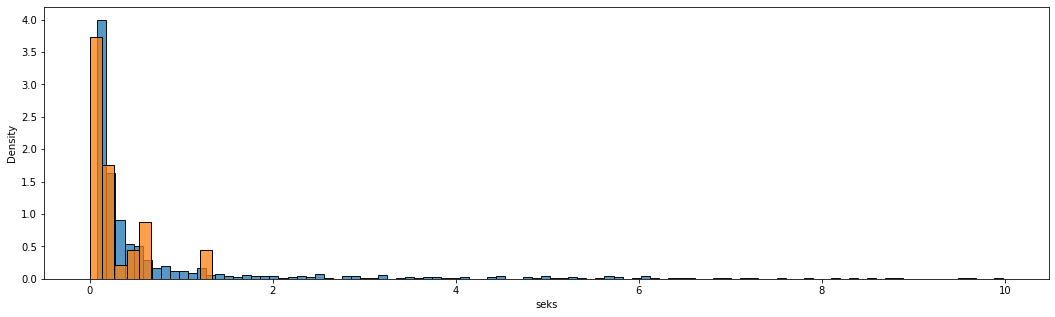

In [67]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
# graph = sns.histplot(data=basic_model_df [(basic_model_df['mu']>-10)&(basic_model_df['mu']<10)], x='mu',ax=axs, bins=100, label='Kid_value' ,stat='density')
graph = sns.histplot(data=basic_model_df [(basic_model_df['seks']>-10)&(basic_model_df['seks']<10)], x='seks',ax=axs, bins=100, label='Kid_value' ,stat='density')
# graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, bins=100, label='Kid_value' ,stat='density')
sns.histplot(df['value_numeric']/(10**6),stat='density',bins=10)

# graph.axvline(basic_model_df.output.mean(), color='red', label='Mean_generated')
# graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, color='green', label='value_numeric' ,bins=20 ,stat='density')
# graph.axvline(df_copy.value_numeric.mean(), color='yellow', label='Mean_observed')
# graph.legend()
# [(basic_model_df['output']>-10)&(basic_model_df['output']<10)]


As can be observed the chosen prior performs well with generating similar distribution for offspring value where the cheaper horses are much more often then the expensive ones. However it does not reflect it perfectly and it should be expanded upon in the future.


# Posterior Check - Model 1 

In [347]:
fit_model_1=CmdStanModel(stan_file='models/v2_model1_post.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/v2_model1_post.stan to exe file /home/racehorse_bayes/models/v2_model1_post


INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/v2_model1_post


In [336]:
df.value_numeric

0      132570.0
1      631605.0
2        8963.0
3        4799.0
4      209211.0
5        2332.0
6        3538.0
7      106087.0
8      636775.0
9      132910.0
10     105932.0
11      33370.0
12      65747.0
13      44277.0
15     537837.0
16     198984.0
17     478021.0
18     516465.0
19     156098.0
20       6321.0
21      62372.0
22     186740.0
23     366760.0
24       2220.0
25     136326.0
27    1340107.0
29     570750.0
33     201404.0
34    1216705.0
35     256468.0
36      13000.0
37     230513.0
38      33375.0
39      72154.0
Name: value_numeric, dtype: float64

In [348]:
data = { 'N': len(df_copy),
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts,
        'seks': df.value_numeric/(10**6)}

fit1=fit_model_1.sample(data=data, iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     show_console=True,
                     seed=20230613)

INFO:cmdstanpy:Chain [1] start processing


INFO:cmdstanpy:Chain [1] done processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 0
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = fixed_param
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmp5f48mfb1/yd3dcd01.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 20230613
Chain [1] output
Chain [1] file = /tmp/tmp5f48mfb1/v2_model1_post-20230713140838.csv
Chain [1] diagnostic_file =  (Default)
Chain [1] refresh = 100 (Default)
Chain [1] sig_figs = -1 (Default)
Chain [1] profile_file = profile.csv (Default)
Chain [1] num_threads = 1 (Default)


In [13]:
# if needed,  uncomment line bolow for analysis purposes
# az.summary(fit1, var_names=['mu'], round_to=2, kind='stats')

In [349]:
predicted_df_output = fit1.stan_variable('seks_pred').flatten()
predicted_df_mu = fit1.stan_variable('mu').flatten()
predicted_df_sigma = fit1.stan_variable('sigma').flatten()


In [ ]:
predicted_df = fit1.draws_pd()
predicted_df.head()

,lp__,accept_stat__,dad_ns_coef,dad_fp_coef,dad_sp_coef,dad_tp_coef,dad_val_coef,mum_ns_coef,mum_fp_coef,mum_sp_coef,...,seks[25],seks[26],seks[27],seks[28],seks[29],seks[30],seks[31],seks[32],seks[33],seks[34]
0,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,9.70534,1.120950,0.679874,0.226152,4.22666,0.008197,0.003255,0.000677,0.304295,0.828739
1,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,10.22520,1.557060,0.855510,0.216773,2.43664,0.024087,0.001796,0.001362,0.301829,0.351450
2,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,15.81930,0.750173,1.058330,0.147361,14.76690,0.022646,0.002441,0.000483,0.309305,0.704513
3,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,14.12460,2.688720,1.150920,0.109320,2.09909,0.008795,0.009628,0.003022,1.181390,1.021840
4,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,67.71990,1.503110,0.749245,0.133137,3.39742,0.014725,0.004747,0.001274,0.562284,0.491853


<AxesSubplot:xlabel='value_numeric', ylabel='Density'>

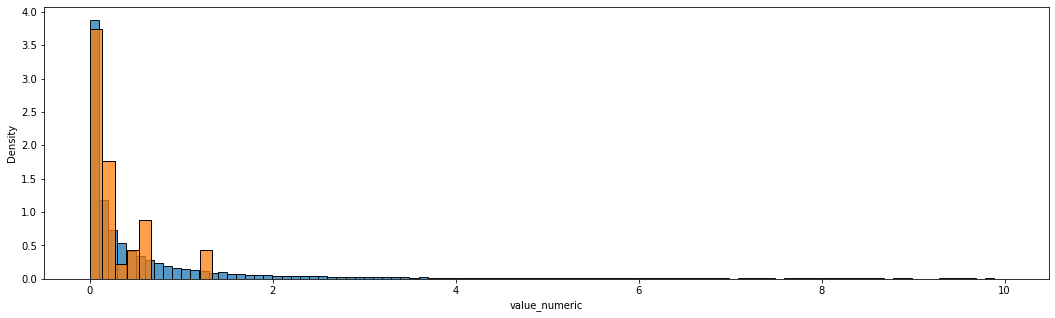

In [351]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
# graph = sns.histplot(predicted_df_mu,ax=axs, bins=100, label='Kid_value' ,stat='density')
graph = sns.histplot(predicted_df_output[predicted_df_output<10] ,bins=100,ax=axs, label='Kid_value' ,stat='density')
sns.histplot(df['value_numeric']/(10**6),stat='density',bins=10)

Model with added posterior predictors performs well within range of the observed data. 
Used data contains peaks that is a result of action bidding. There is a long tail to the right side where values exceed the maximum observed horse values. There is no visible peaks for horses of higher values where interest of investors is reaching their barrier price.

Let's try to fix that in the second model.

# Model 2 description nie bawić się tak po prostu zapisać Mu jako coeffients 
Here we'll use lognormal distribution with altered formulaes. Our reasoning was as follows:

1. Horses prices even for those not having any statisfaing sport results are starting from the value of 1500$.
2. Auction bidding characterictis are responsible for peathek  sden peak around 200 thousand and 1 milion price leve. This is we could say that there are 3 categories of horses based on their pricing: those under 100k, those around 200k, and those arond 1mln. We wanted to simulate the 1mln peak through the addition of our variable `potential_to_be_expensive`. This is a categorical value, set to 1 if a stallion had been on the podium in over 90% of their races, as well as it has been in over 20 races. Otherwise the value is 0. To account for this variable in the formulaes we changed them accordingly (see below).

Formulaes:


The model is created in accordance to the formulae:


$$ output_{value} \sim StudentT(\nu, \mu, \sigma) $$
$$ \mu = predictor_i \cdot \beta + \alpha_0 $$
$$ \sigma \sim Exponential(0.5) $$
$$ \nu \sim Gamma(0.5, 0.5) $$

Where: 

- $ \nu $ - degrees of freedom
- $ \mu $ - mean parameter
- $ \sigma $ - standard deviation parameter
- $ \alpha_0 $ - intercept
- $ \beta $ - vector of chosen coefficients
- $predictor_i$ - data obtained for i'th example







In [ ]:
# adding our special varaible potential_to_be_expensive
firstpart=((df['dad_first_place']+df['dad_second_place']+df['dad_third_place'])>0.9*(df['dad_num_of_starts']))
secondpart=(df['dad_num_of_starts']>20)
df_copy['potential_to_be_expensive']=(firstpart & secondpart).astype(int)
df_copy.head()


,Unnamed: 0,kid_id,mum_id,dad_id,value_numeric,first_place,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts,potential_to_be_expensive
0,0,1,D1,S2,0.097268,0.5000,0.089384,0.209302,0.111111,0.0,0.151515,0
1,2,3,D1,S3,0.469653,0.6875,1.000000,1.000000,0.888889,1.0,1.000000,0
2,3,4,D1,S4,0.005032,0.0625,0.331914,0.325581,0.222222,0.4,0.272727,0
3,4,5,D1,S4,0.001924,0.0625,0.331914,0.325581,0.222222,0.4,0.272727,0
4,7,58,D9,S5,0.154459,0.8750,0.672497,0.488372,0.777778,0.6,0.484848,1


# Model 2 - Pior Predictive - KONSULTACJE MARK1

In [379]:
model2_ppc=CmdStanModel(stan_file='models/v2_model2_ppc_mark1.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/v2_model2_ppc_mark1.stan to exe file /home/racehorse_bayes/models/v2_model2_ppc_mark1


INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/v2_model2_ppc_mark1


In [380]:
data = { 'N': len(df_copy),
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts,
         }

sim_model2_ppc=model2_ppc.sample(data=data, iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     
                     seed=20230613)
basic_model2_df = sim_model2_ppc.draws_pd()
basic_model2_df.head()

basic_model2_df['seks'] = basic_model2_df.loc[:, "seks[1]":f"seks[{len(df_copy)}]"].mean(axis=1)
print(basic_model2_df['seks'])
basic_model2_df_fabs = pd.DataFrame()
basic_model2_df_fabs['seks']  = abs(basic_model2_df['seks'])

INFO:cmdstanpy:CmdStan start processing
chain 1 |▊         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



0      -9.904488e-01
1       7.068173e-02
2       1.999169e-01
3      4.060717e+147
4       3.042855e-01
           ...      
995     1.132734e-01
996     2.343665e+03
997     1.641686e-01
998     1.248878e-01
999     2.606641e+21
Name: seks, Length: 1000, dtype: float64


In [191]:
# R = 1000
# sim_model2_ppc=model2_ppc.sample(iter_sampling=R,
#                      iter_warmup=50,
#                      chains=1,
#                      fixed_param=True,
#                      refresh=R)

# model2_ppc_df = sim_model2_ppc.draws_pd()
# model2_ppc_df.head()

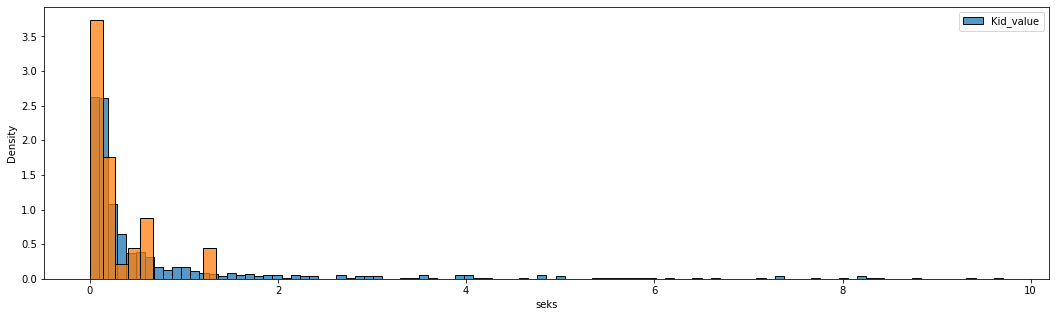

In [381]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
graph = sns.histplot(data=basic_model2_df_fabs[(basic_model2_df_fabs['seks']>-10)&(basic_model2_df_fabs['seks']<10)], x='seks',ax=axs,bins=100, label='Kid_value' ,stat='density')
# graph.axvline(basic_model2_df.kid_value.mean(), color='red', label='Mean_generated')
# graph = sns.histplot(data=model2_ppc_df, x='kid_value_rich',ax=axs,bins=100, label='Kid_value_rich' ,stat='density')
# graph.axvline(model2_ppc_df.kid_value_rich.mean(), color='red', label='Mean_generated_rich')
sns.histplot(df['value_numeric']/(10**6),stat='density',bins=10)
# graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, color='green', label='value_numeric' ,bins=20 ,stat='density')
# graph.axvline(df_copy.value_numeric.mean(), color='yellow', label='Mean_observed')
graph.legend()

## wydaje mi sie ze jest okej ale zapytac huberta o co sie przypierdol

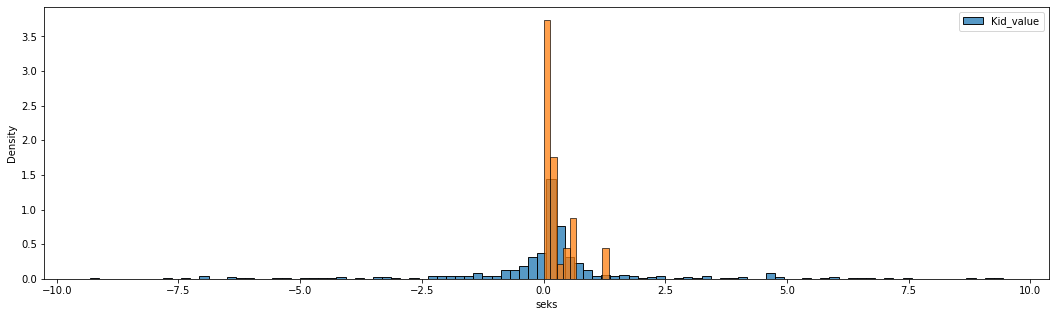

In [182]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
graph = sns.histplot(data=basic_model2_df [(basic_model2_df['seks']>-10)&(basic_model2_df['seks']<10)], x='seks',ax=axs,bins=100, label='Kid_value' ,stat='density')
# graph.axvline(basic_model2_df.kid_value.mean(), color='red', label='Mean_generated')
# graph = sns.histplot(data=model2_ppc_df, x='kid_value_rich',ax=axs,bins=100, label='Kid_value_rich' ,stat='density')
# graph.axvline(model2_ppc_df.kid_value_rich.mean(), color='red', label='Mean_generated_rich')
sns.histplot(df['value_numeric']/(10**6),stat='density',bins=10)
# graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, color='green', label='value_numeric' ,bins=20 ,stat='density')
# graph.axvline(df_copy.value_numeric.mean(), color='yellow', label='Mean_observed')
graph.legend()


It looks like the prior appears to be working -however we can obsevre a heavier tail when compared to eponential distribution prior.

# Prior Predictive check - Model 2 KONSULTACJE MARK 2

In [269]:
model2_ppc_mark2=CmdStanModel(stan_file='models/v2_model2_ppc_mark2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [265]:
data = { 'N': len(df_copy),
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts,
        
         }

sim_model2_ppc_mark2=model2_ppc_mark2.sample(data=data, iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     
                     seed=20230613)
basic_model2_df = sim_model2_ppc_mark2.draws_pd()
basic_model2_df.head()

basic_model2_df['seks'] = basic_model2_df.loc[:, "seks[1]":f"seks[{len(df_copy)}]"].mean(axis=1)
print(basic_model2_df['seks'])
basic_model2_df_fabs = pd.DataFrame()
basic_model2_df_fabs['seks']  = abs(basic_model2_df['seks'])

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.



0      0.032066
1      0.045156
2      0.506004
3      0.939583
4      0.249562
         ...   
995    0.080426
996    0.009401
997    0.015038
998    0.101108
999    0.124236
Name: seks, Length: 1000, dtype: float64


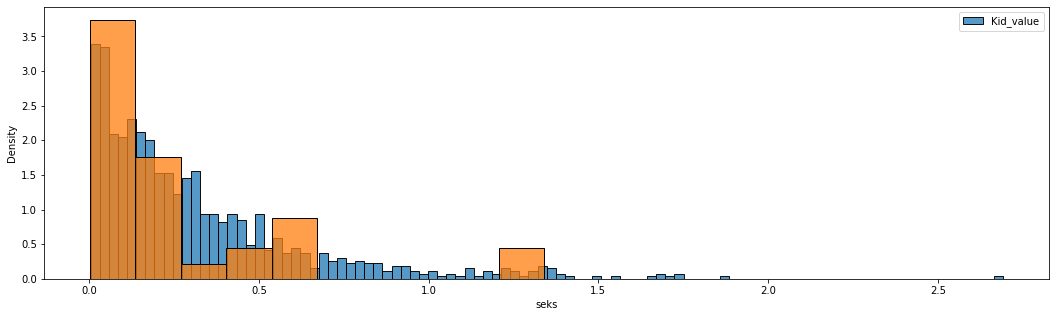

In [222]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
graph = sns.histplot(data=basic_model2_df, x='seks',ax=axs,bins=100, label='Kid_value' ,stat='density')
# graph.axvline(basic_model2_df.kid_value.mean(), color='red', label='Mean_generated')
# graph = sns.histplot(data=model2_ppc_df, x='kid_value_rich',ax=axs,bins=100, label='Kid_value_rich' ,stat='density')
# graph.axvline(model2_ppc_df.kid_value_rich.mean(), color='red', label='Mean_generated_rich')
sns.histplot(df['value_numeric']/(10**6),stat='density',bins=10)
# graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, color='green', label='value_numeric' ,bins=20 ,stat='density')
# graph.axvline(df_copy.value_numeric.mean(), color='yellow', label='Mean_observed')
graph.legend()

# Posterior Predictive check - Model 2  KONSULTACJE MARK 1

In [386]:
model2_fit=CmdStanModel(stan_file='models/v2_model2_post_mark1.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/v2_model2_post_mark1.stan to exe file /home/racehorse_bayes/models/v2_model2_post_mark1
INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/v2_model2_post_mark1


In [387]:
data = { 'N': len(df_copy),
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts,
        'seks': df.value_numeric/(10**6)}

fit2=model2_fit.sample(data=data, iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     
                     seed=20230613)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [319]:
predicted_df = fit2.draws_pd()
predicted_df.head()

,lp__,accept_stat__,dad_ns_coef,dad_fp_coef,dad_sp_coef,dad_tp_coef,dad_val_coef,mum_ns_coef,mum_fp_coef,mum_sp_coef,...,seks_pred[25],seks_pred[26],seks_pred[27],seks_pred[28],seks_pred[29],seks_pred[30],seks_pred[31],seks_pred[32],seks_pred[33],seks_pred[34]
0,0.0,0.0,-1.49579,0.410398,-1.70687,1.9215,0.636535,-0.561583,-1.35416,-0.883738,...,-0.743031,0.037640,0.151231,-0.219751,3.329480,-0.017403,-0.867803,-0.449712,-10.244400,3.648460
1,0.0,0.0,-1.49579,0.410398,-1.70687,1.9215,0.636535,-0.561583,-1.35416,-0.883738,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,-1.49579,0.410398,-1.70687,1.9215,0.636535,-0.561583,-1.35416,-0.883738,...,0.427210,0.124698,0.087919,-0.051939,0.129445,-0.129420,0.041156,0.121282,0.474724,-0.000166
3,0.0,0.0,-1.49579,0.410398,-1.70687,1.9215,0.636535,-0.561583,-1.35416,-0.883738,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,-1.49579,0.410398,-1.70687,1.9215,0.636535,-0.561583,-1.35416,-0.883738,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [400]:
predicted_df_output = fit2.stan_variable('seks_pred').flatten()
# predicted_df_output=abs(predicted_df_output)
print(predicted_df_output)
predicted_df_mu = fit2.stan_variable('mu').flatten()
# predicted_df_sigma = fit1.stan_variable('sigma').flatten()


[ 7.80008e+01 -2.37676e+03  1.09412e+01 ...  4.83315e-03  1.74543e+01
 -6.70693e+00]


TypeError: unsupported operand type(s) for &: 'list' and 'list'

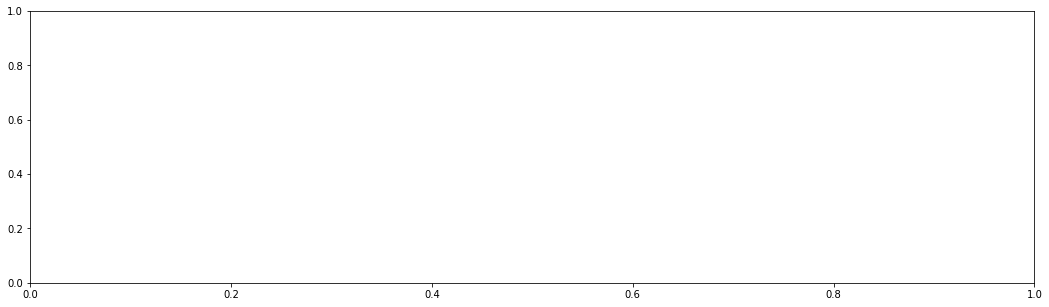

In [409]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
graph = sns.histplot(predicted_df_output([predicted_df_output<10]&[predicted_df_output>-10]),ax=axs, bins=100, label='Kid_value' ,stat='density')
# graph = sns.histplot(predicted_df_mu,bins=70,ax=axs, label='Kid_value' ,stat='density')
# sns.histplot(df['value_numeric']/(10**6),stat='density',bins=10)

# Posterior Check - Model 2 KONSULTACJE MARK2

In [251]:
model2_fit_ver2=CmdStanModel(stan_file='models/v2_model2_post_mark2.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/v2_model2_post_mark2.stan to exe file /home/racehorse_bayes/models/v2_model2_post_mark2


INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/v2_model2_post_mark2


In [252]:
data = { 'N': len(df_copy),
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts,}

fit2_ver2=model2_fit_ver2.sample(data=data, iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     
                     seed=20230613)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [255]:
predicted_df_output_ver2 = fit1.stan_variable('seks').flatten()

print(predicted_df_output)

[  78.7036  2374.68      14.1942  ...    2.70761   15.1168     9.04446]


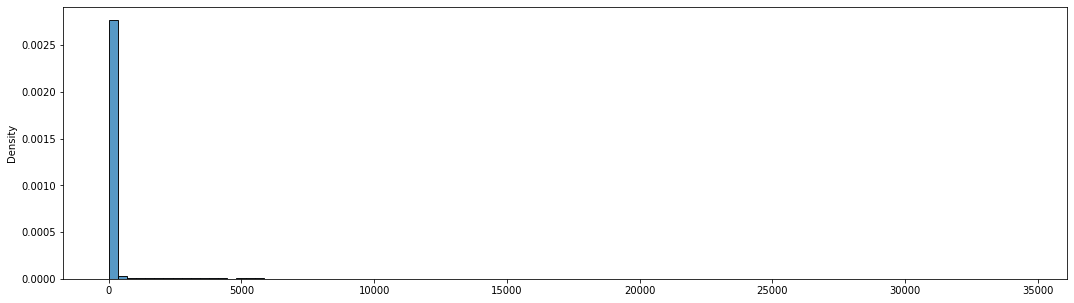

In [257]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
# graph = sns.histplot(data=basic_model_df [(basic_model_df['mu']>-10)&(basic_model_df['mu']<10)], x='mu',ax=axs, bins=100, label='Kid_value' ,stat='density')
graph = sns.histplot(predicted_df_output_ver2 ,bins=100,ax=axs, label='Kid_value' ,stat='density')
# sns.histplot(df['value_numeric']/(10**6),stat='density',bins=10)

 # Model comparison 
 

In [ ]:
fit1_id = az.from_cmdstanpy(posterior=fit1,
                            log_likelihood='log_likelihood',
                            posterior_predictive='kid_value_p',
                            observed_data={'kid_value': df_copy["value_numeric"]})

fit2_id = az.from_cmdstanpy(posterior=fit2,
                            log_likelihood='log_likelihood',
                            posterior_predictive='kid_value_p',
                            observed_data={'kid_value': df_copy["value_numeric"]})

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


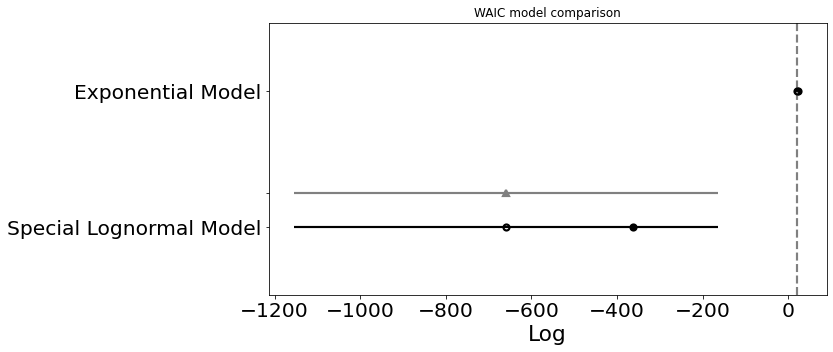

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Exponential Model,0,21.617168,1.897745,0.000000,1.0,8.700010,0.00000,True,log
Special Lognormal Model,1,-659.526865,297.121997,681.144033,0.0,494.627374,495.37643,True,log


In [ ]:
waic = az.compare({'Exponential Model': fit1_id, 'Special Lognormal Model': fit2_id}, ic="waic")
az.plot_compare(waic, figsize=(10, 5))
plt.title("WAIC model comparison")
plt.show()
waic


/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


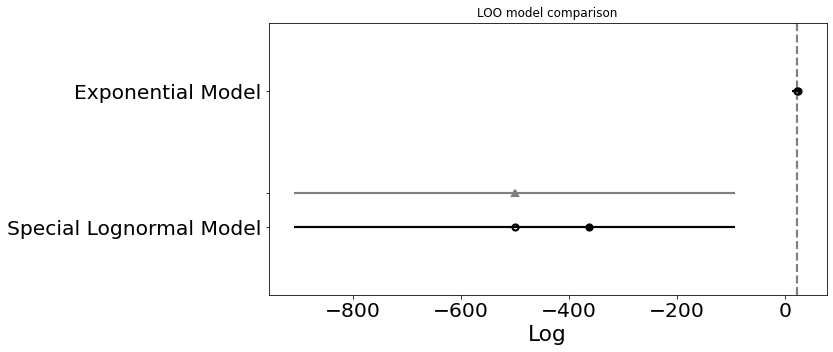

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Exponential Model,0,21.580019,1.934895,0.000000,1.0,8.710942,0.000000,False,log
Special Lognormal Model,1,-500.252253,137.847385,521.832271,0.0,407.828884,408.460121,True,log


In [ ]:
waic = az.compare({'Exponential Model': fit1_id, 'Special Lognormal Model': fit2_id}, ic="loo")
az.plot_compare(waic, figsize=(10, 5))
plt.title("LOO model comparison")
plt.show()
waic


As we can see, both WAIC and LOO comparisons support our initial thought - the exponential model  performs much better than our special case of lognormal approach. 

# Conclusions

The exponential model proved to be a good choice as a starting point for this analysis. However, to fuly show and predict the value of stallion offspring we should add something. For instance, one of the approaches could be to use mixed distributions - e.g. mix of 3 distributions to be exact, one for each horse price range (under 100k, around 200k, and around 1mln). We tried to naively mimic said approach in our model 2, however this approach proved to be much worse than the basic exponential model.